In [79]:
import pandas as pd
import numpy as np
import re
import math
import spacy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import text
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [80]:
def getData():
    data1 = pd.read_csv("../data/names/Popular_Baby_Names.csv",delimiter=',')
    data1 = data1.rename(columns={"Child's First Name": "Name"})
    columns = ['Name', 'Gender']
    data1 = data1[columns]
    data1['Gender'] = data1['Gender'].str.lower()
    
    data2 = pd.read_csv("../data/names/female-names.txt", names = ['Name'])
    data2['Gender'] = "female"
    
    data3 = pd.read_csv("../data/names/male-names.txt", names = ['Name'])
    data3['Gender'] = "male"
        
    data4 = pd.read_csv("../data/names/From_Aadhav_to_Zyva__6_087_Names_of_Babies_Born_in_Austin_in_2017.csv")
    data4 = data4.rename(columns={"SEX": "Gender", "FIRST NAME":"Name"})
    columns = ['Name', 'Gender']
    data4 = data4[columns]
    data4['Gender'] = np.where((data4['Gender'] == 'GIRL'),'female',data4['Gender'])
    data4['Gender'] = np.where((data4['Gender'] == 'BOY'),'male',data4['Gender'])
    
    data5 = pd.read_csv("../data/names/Most_Popular_Baby_Names_2008-2017_City_Of_Austin.csv")
    d6 = pd.DataFrame(columns = columns)
    d6['Name'] = data5['Girls']
    d6['Gender'] = 'female'
    
    d7 = pd.DataFrame(columns = columns)
    d7['Name'] = data5['Boys']
    d7['Gender'] = 'male'
    
    data8 = pd.read_json('../data/names/ENGivenMale.json')
    data8 = data8[['name']]
    data8['Gender'] = 'male'
    data8 = data8.rename(columns={"name": "Name"})
    
    data = pd.concat([data1, data2, data3, data4, d6, d7, data8], ignore_index=True)
    data['Name'] = data['Name'].str.lower()
    data = data.drop_duplicates(subset = ["Name"], ignore_index=True)
    data = data[:-5]
    
    data = shuffle(data).reset_index(drop=True)
    
    return data

In [81]:
data = getData()
# data[data.duplicated(keep=False)]

In [82]:
data

,Name,Gender
0,indira,female
1,kizzee,female
2,donnell,male
3,emalee,female
4,william,male
...,...,...
12143,shirl,female
12144,chelton,male
12145,bianca,female
12146,d'vante,male


In [6]:
# data.to_csv('../data/names/all-names.csv', index=False)

In [7]:
def getLength(name):
    return len(name)

In [8]:
data["Length"] = data["Name"].apply(getLength)
data

,Name,Gender,Length
0,alexina,female,7
1,yalini,female,6
2,saisha,female,6
3,maliya,female,6
4,kadyn,male,5
...,...,...,...
12143,warde,male,5
12144,bexar,male,5
12145,lucia,female,5
12146,melli,female,5


In [9]:
data = data[data['Length'] <12]

In [10]:
data = data.drop(columns=['Length'])

In [11]:
def numberOfMF(data):
    print(data.shape)
    df = data.groupby('Gender')['Name'].count()
    df = pd.DataFrame({'Names': [df[0], df[1]]}, index=['Female', 'Male'])
    plot = df.plot.pie(subplots=True, figsize=(11, 6), colors = ['#ffb3e6','#c2c2f0'], 
                       autopct = "%.2f%%", labeldistance=1.15)

In [12]:
numberOfMF(data)

(12017, 2)


In [13]:
def checkGender(gender):
    if gender == "female":
        return 1
    return 0

In [14]:
data["GenderCode"] = data["Gender"].apply(checkGender)
data

,Name,Gender,GenderCode
0,alexina,female,1
1,yalini,female,1
2,saisha,female,1
3,maliya,female,1
4,kadyn,male,0
...,...,...,...
12143,warde,male,0
12144,bexar,male,0
12145,lucia,female,1
12146,melli,female,1


# Features

In [15]:
def checkEnd(name):
    if name[-1] in "aeiou":
        return "vowel"
    return "consonant"

In [16]:
data["EndsWith"] = data["Name"].apply(checkEnd)
data

,Name,Gender,GenderCode,EndsWith
0,alexina,female,1,vowel
1,yalini,female,1,vowel
2,saisha,female,1,vowel
3,maliya,female,1,vowel
4,kadyn,male,0,consonant
...,...,...,...,...
12143,warde,male,0,vowel
12144,bexar,male,0,consonant
12145,lucia,female,1,vowel
12146,melli,female,1,vowel


### 2.1.2 Verification of the feature: Name ends with vowel or not 

In [17]:
def compare(group):
    return data.groupby([group])["GenderCode"].sum()*100/data.groupby([group])["GenderCode"].count()

In [18]:
print(compare("EndsWith"))

EndsWith
consonant    40.252951
vowel        82.602267
Name: GenderCode, dtype: float64


*We see that roughly 30% of names ending with consonants, and 80% of names ending with vowels, are female.*

In [19]:
def getRatio(data, col, val1, val2):
    temp = data[data['GenderCode'] == 1]
    f_v = temp[temp[col] == val1].shape[0]
    f_c = temp[temp[col] == val2].shape[0]
    
    temp = data[data['GenderCode'] == 0]
    m_v = temp[temp[col] == val1].shape[0]
    m_c = temp[temp[col] == val2].shape[0]

    return f_v, f_c, m_v, m_c

In [20]:
def plotRatio(f_v, f_c, m_v, m_c, idx1, idx2, title):
    df = pd.DataFrame({'Female': [f_v, f_c], 'Male': [m_v, m_c]}, index=[idx1, idx2])
    plot = df.plot.pie(subplots=True, figsize=(11, 6), colors = ['#66b3ff','#99ff99'],
                      autopct = "%.2f%%", labeldistance=1.15, title=title)

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


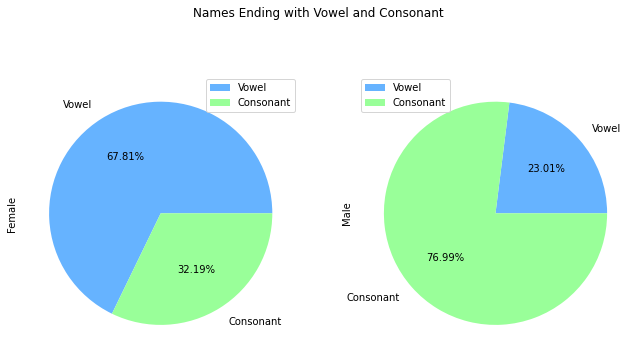

In [21]:
f_v, f_c, m_v, m_c = getRatio(data, 'EndsWith', 'vowel', 'consonant')
plotRatio(f_v, f_c, m_v, m_c, 'Vowel', 'Consonant', 'Names Ending with Vowel and Consonant')

In [22]:
def getStat(data, group):
    male = data.loc[data['Gender'] == 'male']
    female = data.loc[data['Gender'] == 'female']
    maleLen = pd.DataFrame(male.value_counts([group]).reset_index(name='Count'))
    femaleLen = pd.DataFrame(female.value_counts([group]).reset_index(name='Count'))
    index = np.sort(maleLen[group])
    df = pd.DataFrame({'Female': femaleLen['Count'], 'Male': maleLen['Count']}, index=index)
    ax = df.plot.bar(figsize=(12,4),rot=0, color={"Female": "#ffb3e6", "Male": "#c2c2f0"}, width=0.7, grid=1, ylabel="Count of Names")
    return femaleLen, maleLen

## 2.4 Count of vowels and consonants

### 2.4.1 Count Vowels and Consonants in a name

In [23]:
def letterClass(name):
    name_list = [x for x in name]
    vowel_counter = 0
    consonant_counter = 0
    for letter in name_list:
        if letter in ['a','e','i','o','u']:
            vowel_counter+=1
        else:
            consonant_counter+=1
    
    return vowel_counter, consonant_counter

In [24]:
data['VowelCount'] = data['Name'].apply(lambda x: letterClass(x)[0])
data['ConsonantCount'] = data['Name'].apply(lambda x: letterClass(x)[1])

In [25]:
data

,Name,Gender,GenderCode,EndsWith,VowelCount,ConsonantCount
0,alexina,female,1,vowel,4,3
1,yalini,female,1,vowel,3,3
2,saisha,female,1,vowel,3,3
3,maliya,female,1,vowel,3,3
4,kadyn,male,0,consonant,1,4
...,...,...,...,...,...,...
12143,warde,male,0,vowel,2,3
12144,bexar,male,0,consonant,2,3
12145,lucia,female,1,vowel,3,2
12146,melli,female,1,vowel,2,3


### 2.4.2 Finding Threshold

#### 2.4.2.1 Comparing number of male/female names on the basis of vowelCount and ConsonantCount

#### 2.4.2.2 Comparing number of vowels and consonants in maleNames and femaleNames

In [26]:
def compareVowels(data):
    data['vcCompare']= np.where(data['ConsonantCount'] == data['VowelCount'], 'equal', np.where(
    data['ConsonantCount'] > data['VowelCount'], 'moreConsonants', 'moreVowels')) 

In [27]:
compareVowels(data)
data

,Name,Gender,GenderCode,EndsWith,VowelCount,ConsonantCount,vcCompare
0,alexina,female,1,vowel,4,3,moreVowels
1,yalini,female,1,vowel,3,3,equal
2,saisha,female,1,vowel,3,3,equal
3,maliya,female,1,vowel,3,3,equal
4,kadyn,male,0,consonant,1,4,moreConsonants
...,...,...,...,...,...,...,...
12143,warde,male,0,vowel,2,3,moreConsonants
12144,bexar,male,0,consonant,2,3,moreConsonants
12145,lucia,female,1,vowel,3,2,moreVowels
12146,melli,female,1,vowel,2,3,moreConsonants


#### 2.4.2.3 Difference between the number of vowels and consonants in maleNames and femaleNames

In [28]:
def checkVCDifference(data):
    data['vcDifference']= data['ConsonantCount'] - data['VowelCount']

In [29]:
checkVCDifference(data)
data

,Name,Gender,GenderCode,EndsWith,VowelCount,ConsonantCount,vcCompare,vcDifference
0,alexina,female,1,vowel,4,3,moreVowels,-1
1,yalini,female,1,vowel,3,3,equal,0
2,saisha,female,1,vowel,3,3,equal,0
3,maliya,female,1,vowel,3,3,equal,0
4,kadyn,male,0,consonant,1,4,moreConsonants,3
...,...,...,...,...,...,...,...,...
12143,warde,male,0,vowel,2,3,moreConsonants,1
12144,bexar,male,0,consonant,2,3,moreConsonants,1
12145,lucia,female,1,vowel,3,2,moreVowels,-1
12146,melli,female,1,vowel,2,3,moreConsonants,1


### 2.4.3 Creating the feature

#### 2.4.3.1 Creating Vowel and Consonant Count feature
This is on the basis of just the count of vowels or just the count of consonants. So, whether the vowels are high or low in number is one feature and whether the consonants are high or low in number is another feature.

In [30]:
def checkVowelCount(col):
    if col > 2:
        return 'more'
    return 'less'

def checkConsonantCount(col):
    if col > 3:
        return 'more'
    return 'less'

In [31]:
data["VowelCountClass"] = data["VowelCount"].apply(checkVowelCount)
data["ConsonantCountClass"] = data["ConsonantCount"].apply(checkConsonantCount)
data

,Name,Gender,GenderCode,EndsWith,VowelCount,ConsonantCount,vcCompare,vcDifference,VowelCountClass,ConsonantCountClass
0,alexina,female,1,vowel,4,3,moreVowels,-1,more,less
1,yalini,female,1,vowel,3,3,equal,0,more,less
2,saisha,female,1,vowel,3,3,equal,0,more,less
3,maliya,female,1,vowel,3,3,equal,0,more,less
4,kadyn,male,0,consonant,1,4,moreConsonants,3,less,more
...,...,...,...,...,...,...,...,...,...,...
12143,warde,male,0,vowel,2,3,moreConsonants,1,less,less
12144,bexar,male,0,consonant,2,3,moreConsonants,1,less,less
12145,lucia,female,1,vowel,3,2,moreVowels,-1,more,less
12146,melli,female,1,vowel,2,3,moreConsonants,1,less,less


/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


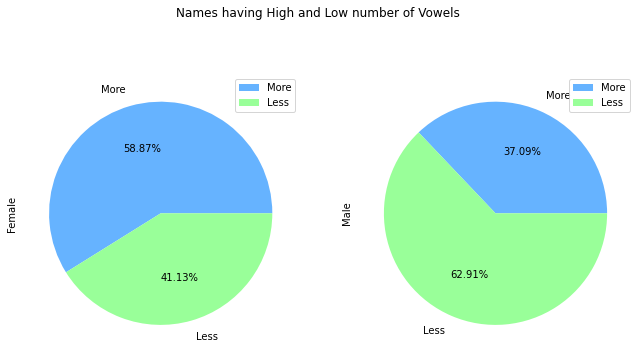

In [32]:
f_h, f_l, m_h, m_l = getRatio(data, 'VowelCountClass', 'more', 'less')
plotRatio(f_h, f_l, m_h, m_l, 'More', 'Less', 'Names having High and Low number of Vowels')

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


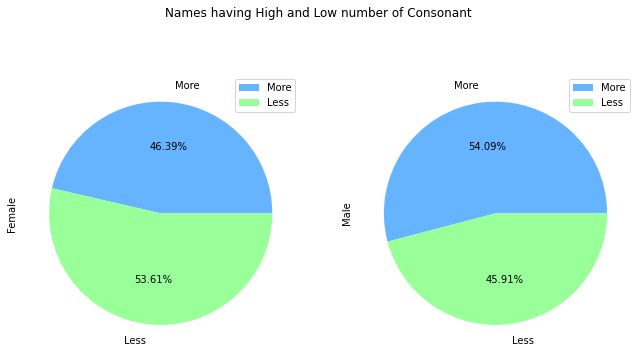

In [33]:
f_h, f_l, m_h, m_l = getRatio(data, 'ConsonantCountClass', 'more', 'less')
plotRatio(f_h, f_l, m_h, m_l, 'More', 'Less', 'Names having High and Low number of Consonant')

#### 2.4.3.2 Creating MoreVowels feature

This is on the basis of the count of vowels compared to count of consonants in one name.

In [91]:
def checkMoreVowels(col):
    if col == 'moreConsonants':
        return 'less'
    return 'more'

In [92]:
data["MoreVowels"] = data["vcCompare"].apply(checkMoreVowels)
data

,Name,Gender,GenderCode,EndsWith,VowelCount,ConsonantCount,vcCompare,vcDifference,VowelCountClass,ConsonantCountClass,MoreVowels
0,bernadina,female,1,vowel,4,5,moreConsonants,1,more,more,less
1,robin,female,1,consonant,2,3,moreConsonants,1,less,less,less
2,kellsie,female,1,vowel,3,4,moreConsonants,1,more,more,less
3,remington,male,0,consonant,3,6,moreConsonants,3,more,more,less
4,erminia,female,1,vowel,4,3,moreVowels,-1,more,less,more
...,...,...,...,...,...,...,...,...,...,...,...
12143,roselynn,female,1,consonant,2,6,moreConsonants,4,less,more,less
12144,kayley,female,1,consonant,2,4,moreConsonants,2,less,more,less
12145,brisa,female,1,vowel,2,3,moreConsonants,1,less,less,less
12146,adriana,female,1,vowel,4,3,moreVowels,-1,more,less,more


/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


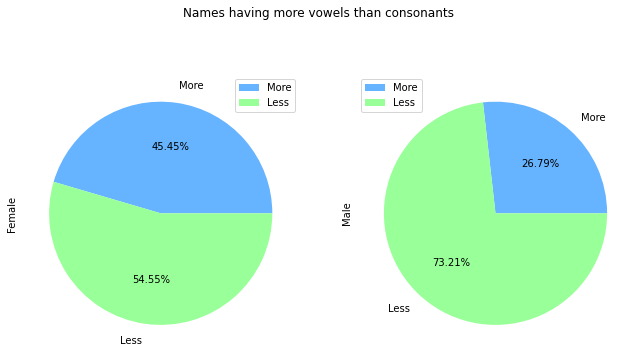

In [93]:
f_h, f_l, m_h, m_l = getRatio(data, 'MoreVowels', 'more', 'less')
plotRatio(f_h, f_l, m_h, m_l, 'More', 'Less', 'Names having more vowels than consonants')

#### 2.4.3.3 Creating VC difference feature
Choosing 0 as a threshold would give the same result as the feature above.

In [76]:
def checkMoreDifference(col):
    if col == 2:
        return 'more'
    return 'less'

In [77]:
data["MoreDifferenceClass"] = data["vcDifference"].apply(checkMoreDifference)
data

,Name,Gender,GenderCode,EndsWith,VowelCount,ConsonantCount,vcCompare,vcDifference,VowelCountClass,ConsonantCountClass,MoreDifferenceClass
0,alexina,female,1,vowel,4,3,moreVowels,-1,more,less,less
1,yalini,female,1,vowel,3,3,equal,0,more,less,less
2,saisha,female,1,vowel,3,3,equal,0,more,less,less
3,maliya,female,1,vowel,3,3,equal,0,more,less,less
4,kadyn,male,0,consonant,1,4,moreConsonants,3,less,more,less
...,...,...,...,...,...,...,...,...,...,...,...
12143,warde,male,0,vowel,2,3,moreConsonants,1,less,less,less
12144,bexar,male,0,consonant,2,3,moreConsonants,1,less,less,less
12145,lucia,female,1,vowel,3,2,moreVowels,-1,more,less,less
12146,melli,female,1,vowel,2,3,moreConsonants,1,less,less,less


/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


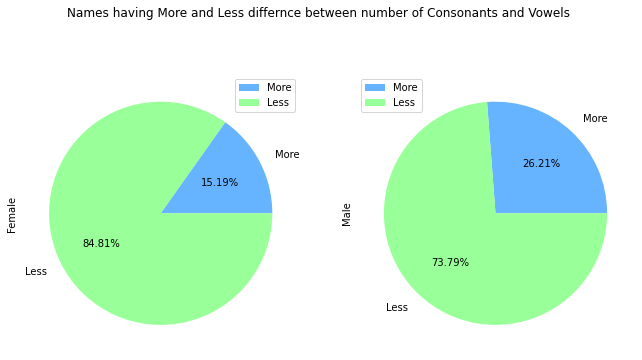

In [78]:
f_h, f_l, m_h, m_l = getRatio(data, 'MoreDifferenceClass', 'more', 'less')
plotRatio(f_h, f_l, m_h, m_l, 'More', 'Less', 'Names having More and Less differnce between number of Consonants and Vowels')

*As predicted, choosing 0 as a threshold gives the same result as the previous feature. Therefore, instead of creating a feature by putting a threshold, we can use the difference of vowels and consonants it self as a feature. So, we should drop the 'MoreDifferenceClass' feature now.*

## 2.5 ASCII Values

In [83]:
def getASCII(name):
    asciiVal = 0
    for x in name:
        asciiVal += ord(x)-97
    return asciiVal/len(name)

In [84]:
data["ASCIIval"] = data["Name"].apply(getASCII)
data

,Name,Gender,ASCIIval
0,indira,female,8.166667
1,kizzee,female,12.666667
2,donnell,male,9.857143
3,emalee,female,5.833333
4,william,male,10.285714
...,...,...,...
12143,shirl,female,12.200000
12144,chelton,male,10.000000
12145,bianca,female,4.000000
12146,d'vante,male,0.285714


In [99]:
def dropColumns(data, collist):
    data = data.drop(columns=collist)
    return data

In [100]:
data = dropColumns(data, ['vcCompare', 'ConsonantCountClass', 'Gender', 'Name'])

In [101]:
data

,GenderCode,EndsWith,VowelCount,ConsonantCount,vcDifference,VowelCountClass,MoreVowels,MoreDifferenceClass,ASCIIval
0,1,vowel,4,5,1,more,less,less,6.555556
1,1,consonant,2,3,1,less,less,less,10.600000
2,1,vowel,3,4,1,more,less,less,9.428571
3,0,consonant,3,6,3,more,less,more,11.777778
4,1,vowel,4,3,-1,more,more,less,8.857143
...,...,...,...,...,...,...,...,...,...
12143,1,consonant,2,6,4,less,less,more,14.250000
12144,1,consonant,2,4,2,less,less,more,12.166667
12145,1,vowel,2,3,1,less,less,less,8.800000
12146,1,vowel,4,3,-1,more,more,less,5.857143


In [102]:
def makeBinary(data, cols, zero, one):
    for col in cols:
        data[col] = np.where((data[col] == zero),0,data[col])        
        data[col] = np.where((data[col] == one),1,data[col])
    return data

In [103]:
data = makeBinary(data, ['VowelCountClass', 'MoreVowels', 'MoreDifferenceClass'], 'less', 'more')

In [104]:
data = makeBinary(data, ['EndsWith'], 'consonant', 'vowel')

In [105]:
data

,GenderCode,EndsWith,VowelCount,ConsonantCount,vcDifference,VowelCountClass,MoreVowels,MoreDifferenceClass,ASCIIval
0,1,1,4,5,1,1,0,0,6.555556
1,1,0,2,3,1,0,0,0,10.600000
2,1,1,3,4,1,1,0,0,9.428571
3,0,0,3,6,3,1,0,1,11.777778
4,1,1,4,3,-1,1,1,0,8.857143
...,...,...,...,...,...,...,...,...,...
12143,1,0,2,6,4,0,0,1,14.250000
12144,1,0,2,4,2,0,0,1,12.166667
12145,1,1,2,3,1,0,0,0,8.800000
12146,1,1,4,3,-1,1,1,0,5.857143


# Training model

In [118]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
def getResults(predictions, testlabels):
    print("Accuracy: ", accuracy_score(testlabels, predictions))
#     print("Recall: ", recall_score(testlabels, predictions, ['0', '1'], average=None))
#     print("Precision: ", precision_score(testlabels, predictions, ['0', '1'], average=None))
#     print("F1-score: ",f1_score(testlabels, predictions, ['0', '1'], average=None))
    cm = confusion_matrix(testlabels, predictions)
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                 cm.flatten()]
#     group_percentages = ["{0:.2%}".format(value) for value in
#                      cm.flatten()/np.sum(cm)]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#           zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
    fig = plt.subplots(figsize=[4,4])
    fig = sns.heatmap(cm/np.sum(cm), fmt='.2%',annot=True, cmap='Blues', cbar=False)
    plt.xticks([0.5, 1.5], ['Male','Female'])
    plt.yticks([0.5, 1.5], ['Male','Female'])
    plt.xlabel('Predicted Genders')
    plt.ylabel('Actual Genders')

In [120]:
train, test = train_test_split(data, test_size = 0.20)
trainlabels = train.pop('GenderCode')
testlabels = test.pop('GenderCode')

## 1. Decision Tree Classifier

In [121]:
clf = DecisionTreeClassifier()
clf = clf.fit(train, trainlabels)

In [122]:
clf.feature_importances_

array([0.46940523, 0.03774175, 0.04914941, 0.05589013, 0.00479341,
       0.00735818, 0.00839291, 0.36726897])

In [123]:
predictions = clf.predict(test)

Accuracy:  0.6755407653910149


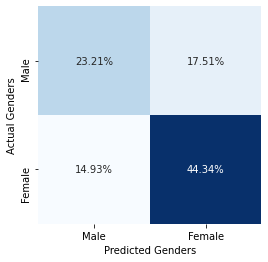

In [124]:
getResults(testlabels, predictions)

In [143]:
pickle.dump(clf, open("./models/dtc-task1", 'wb'))

## 2. SVM

In [125]:
from sklearn.svm import SVC
svm = SVC(kernel="linear")
svm = svm.fit(train, trainlabels)

In [126]:
predictions = svm.predict(test)

Accuracy:  0.7071547420965059


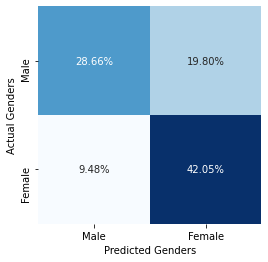

In [127]:
getResults(testlabels, predictions)

In [128]:
pickle.dump(svm, open("./models/svm-task1", 'wb'))

## 3. kMeans

In [129]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(train, trainlabels)

KMeans(n_clusters=2, random_state=0)

Accuracy:  0.6035773710482529


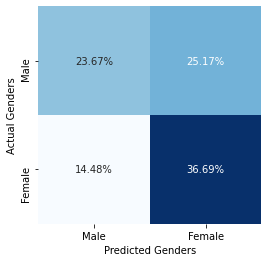

In [130]:
predictions = kmeans.predict(test)
getResults(testlabels, predictions)

In [131]:
pickle.dump(kmeans, open("./models/kmeans-task1", 'wb'))

## 4. Random Forest Classifier

In [132]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=1, n_estimators=400)
rfc.fit(train, trainlabels)

RandomForestClassifier(n_estimators=400, random_state=1)

Accuracy:  0.6821963394342762


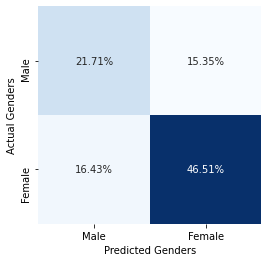

In [133]:
predictions = rfc.predict(test)
getResults(testlabels, predictions)

In [134]:
pickle.dump(kmeans, open("./models/rfc-task1", 'wb'))

## 5. Logistic Regression

In [135]:
logreg = LogisticRegression(random_state=42).fit(train, trainlabels)

Accuracy:  0.7100665557404326


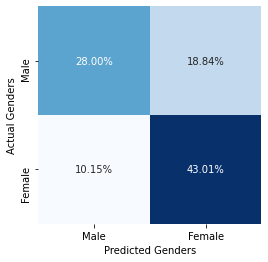

In [136]:
predictions = logreg.predict(test)
getResults(testlabels, predictions)

In [137]:
pickle.dump(logreg, open("./models/LogReg-task1", 'wb'))